In [1]:
import glob
import os
from lsst import afw
print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry
import numpy

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std

import scipy
from scipy.ndimage import gaussian_filter
from scipy import signal
from scipy.fftpack import fft, fftshift

import numpy as np
import matplotlib.pyplot as plt
import math


from mytool import plotonesensor_E2V, plotonesensor_E2V_smooth

%matplotlib inline

20.0.0-4-gde602ef96+1


[ 319.994  324.969  349.982  374.975  400.019  424.965  450.035  475.003
  500.018  525.002  550.029  575.023  599.982  619.997  624.979  650.012
  675.004  700.03   725.012  750.022  774.987  799.976  824.988  850.022
  869.967  875.002  899.999  919.999  925.012  949.965  975.002  999.976
 1025.028 1050.014 1075.002 1099.99 ]


Text(0.5, 1.0, 'Response Curve/SED for CCOB$_{R}$')

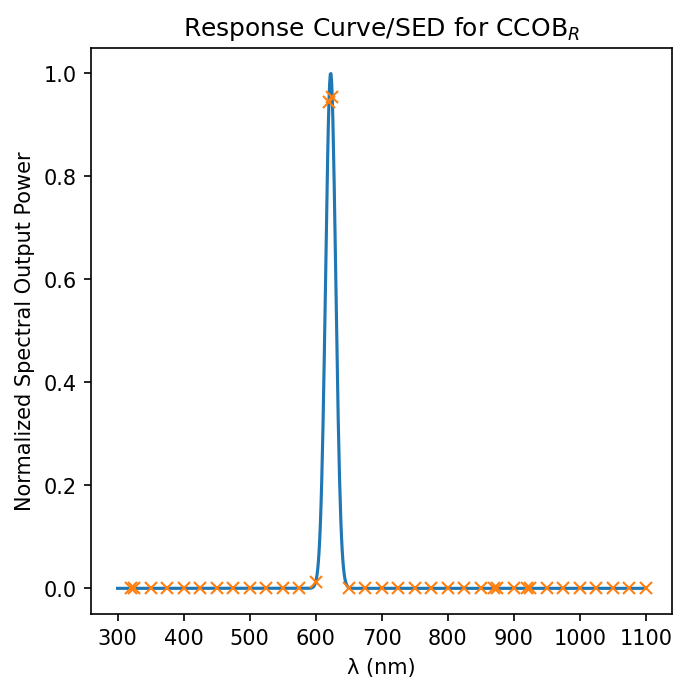

In [2]:
superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-024/RTM-024-11351-S11_superbias_normal.fits"
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-024/RTM-024-11351-S11_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-024/11351/qe_raft_acq/v0/88290/S11/*_lambda_flat_*") 
qeflatpath.sort()


# array of wavelengths
wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])
print(wls)



# SED plot for red band
fig, axs = pylab.subplots(figsize=(5,5),dpi=150)

wavelengths_list = [365, 466.6, 622.6, 759.9, 845.7, 950.5]
width_of_wavelength_list = [12, 25, 18, 28, 32, 60]
width_of_wavelength_list_converted = []
for num in width_of_wavelength_list:
    z = num / 2.355
    width_of_wavelength_list_converted.append(z)
# now wavelength widths converted from FWHM to sigma


# want to use the RED band, so the third element in each list
mu = wavelengths_list[2]
sigma = width_of_wavelength_list_converted[2]

a = 1    # to normalize
x = numpy.arange(300,1100,1)  
y = a*numpy.exp(-(x-mu)**2/(2*sigma**2))
pylab.plot(x, y)

weights = numpy.interp(wls, x, y)   
# plots 'x's
pylab.plot(wls, weights,"x")

pylab.xlabel("λ (nm)")
pylab.ylabel("Normalized Spectral Output Power")
pylab.title("Response Curve/SED for CCOB$_{R}$")

In [3]:
superdark = get_ccd_from_id(None, superdarkpath, [])     # load superdark
superbias = get_ccd_from_id(None, superbiaspath, [])     # load superbias


num_ch  = 16    
img_list = []
MEDIAN = None

for ch in range(num_ch):
    arr = []       
    for i, aqeflatpath in enumerate(qeflatpath):
        aqeflat = get_ccd_from_id(None, aqeflatpath, [], bias_frame=superbias)
    
        img = aqeflat.unbiased_and_trimmed_image(ch + 1).getImage().array
        
        MEDIAN = numpy.median(img)
        img = img/MEDIAN     # this will normalize your image

        arr.append(img*weights[i])
        
    img = numpy.sum(arr,axis=0)/numpy.sum(weights) 
    std = mad_std(img)
    
    img_list.append(img)    # working with E2V sensors not, not ITL so flipped bottom and top row here
    
"""
What you might want to do is that to tweak the part you are reading and normalize amplifiers so that level of amplifiers match each other.
Because we measure gain in different way, we can use those measurement. However, we were not 100% sure what numbers of gains Celine used, we will take an approach that we'll 
adjust them internally in a sensor. 

So measuring the median number of an amplifier, divide the image by the median, and repeat this for remaining amplifiers. 
Then the all amplifiers will be normalized by 1, and gain-matched relatively. 
"""

"\nWhat you might want to do is that to tweak the part you are reading and normalize amplifiers so that level of amplifiers match each other.\nBecause we measure gain in different way, we can use those measurement. However, we were not 100% sure what numbers of gains Celine used, we will take an approach that we'll \nadjust them internally in a sensor. \n\nSo measuring the median number of an amplifier, divide the image by the median, and repeat this for remaining amplifiers. \nThen the all amplifiers will be normalized by 1, and gain-matched relatively. \n"

In [5]:
# code for displaying one full E2V CCD 
def plotonesensor_E2V(img_list, title):
    
    fig=plt.figure(figsize=(5, 5), dpi=150)   
    columns = 8
    rows = 2
    
    image_com = None
    wholepixels = numpy.array(img_list).flatten()
    mean = numpy.mean(wholepixels,dtype=numpy.float64)
    std = numpy.std(wholepixels,dtype=numpy.float64)
    ax = []

    for i in range(num_ch):
        if i < columns:
            image_com = numpy.rot90(img_list[i + 8], 2)
        else:
            image_com = img_list[num_ch - (i + 1)]

        ax1 = fig.add_subplot(rows, columns, i + 1)
        ax.append(ax1)
        ax1.set_xticks([])   
        ax1.set_yticks([])

        N = 0.3
        im = plt.imshow(image_com, vmin=mean-N*std,vmax=mean+N*std,origin="lower")
        
    plt.suptitle(title)
    cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
    cbar.ax.tick_params(labelsize=8)
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()


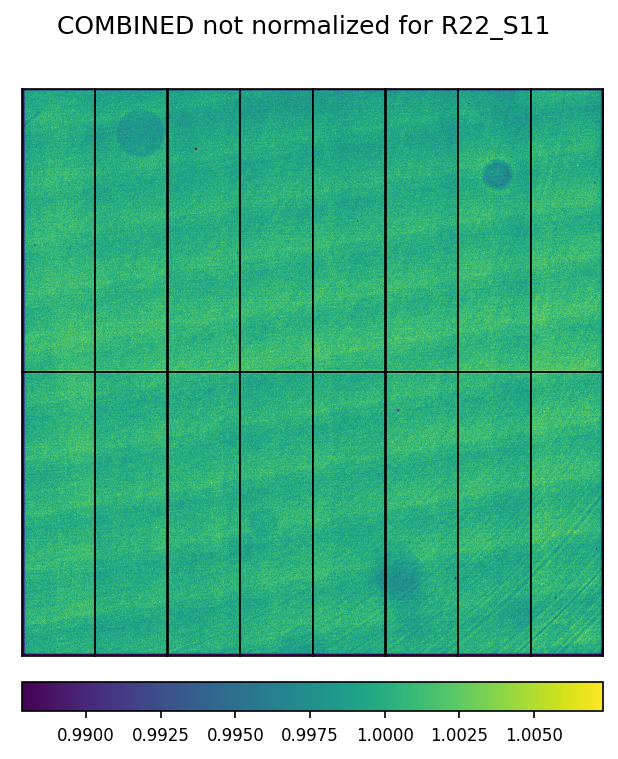

In [6]:
# This is fine if looking at an image before gain correction. And the COMBINED image is not gain corrected. So it's fine, but we're suspecting that the CCOB flat is gain corrected.
# This looks different than COMBINED. We have another normalization that makes the mean level of COMBINE flat the mean level of CCOB flat, different than here.  

plotonesensor_E2V(img_list, "COMBINED not normalized for R22_S11")

In [7]:
### R22_S11
# Here we make the mean flat level of COMBINED match the mean flat level of CCOB amplifier-by-amplifier. The purpose of this cell is to normalize the COMBINED flat to the CCOBred.
# Here we are normalizing amp-by-amp rather than an overall normalization (before for loop)

# To avoid complication, the part where I divided amplifiers into two different arrays (red_top, red_bot, etc.) has been removed. Now the amp data is in ONE array. 

red_arr = [None] * num_ch
normedimg_arr = [None] * num_ch
MEDIAN = None

fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R22_S11_red_-10.005_10.245.fits"     ##  center pointing
ccob_red = get_ccd_from_id(None, fname, [])

for ch in range(num_ch):    
    red = get_data_as_read(ccob_red,ch + 1,["imaging"])["imaging"]    # QE data array
    MEDIAN = numpy.median(red)                                        # median (not mean, avoiding outliers) of QE data array for CCOBred, will normalize COMBINED with this
    normedimg = img_list[ch] / numpy.median(img_list[ch]) * MEDIAN    # normalizing COMBINED against the CCOB amp-by-amp to the level of the CCOB median 
    normedimg_arr[ch] = normedimg                                     # adding data at this amp to data array
    red_arr[ch] = red        
    
 

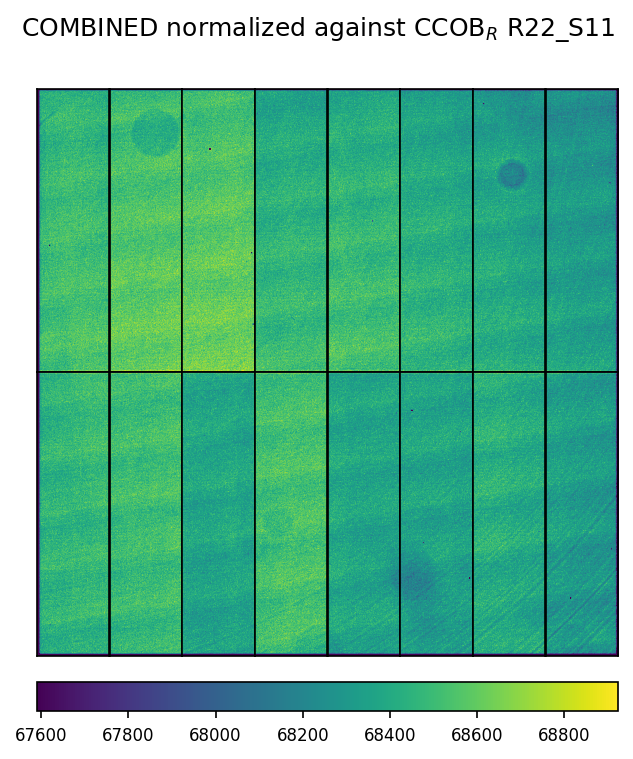

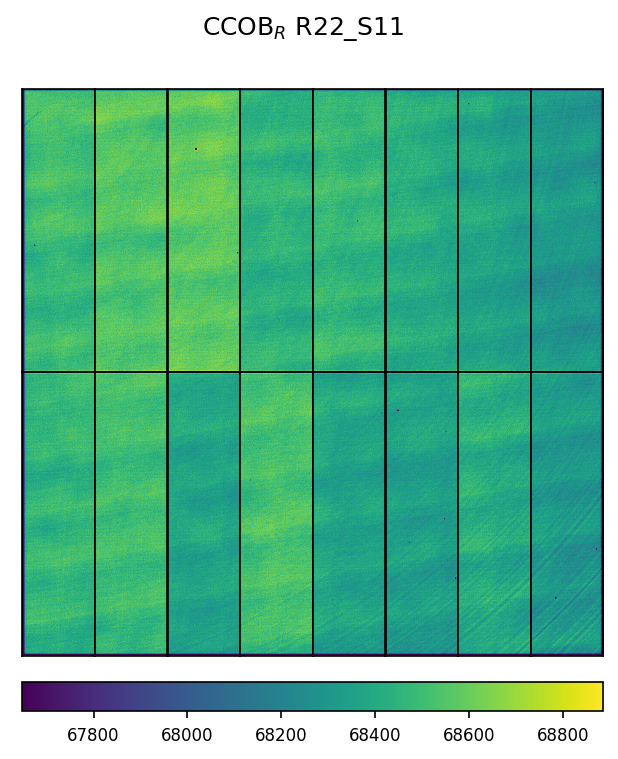

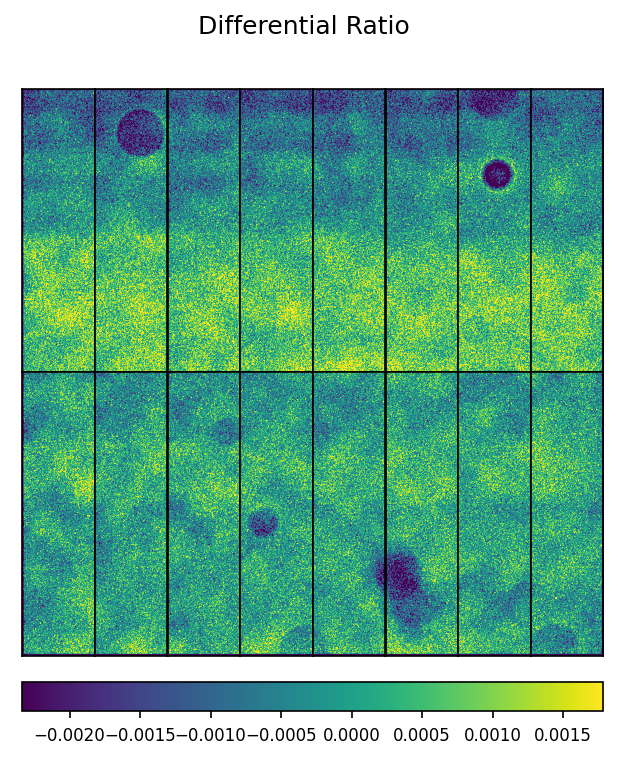

In [8]:
# plot normalized, COMBINED flat
plotonesensor_E2V(normedimg_arr, 'COMBINED normalized against CCOB$_{R}$ R22_S11')

# plot CCOBred flat
plotonesensor_E2V(red_arr, 'CCOB$_{R}$ R22_S11')

# plot Ratio flat, the one of interest!
diff_arr = [None] * num_ch
for i in range(num_ch):
    diff_arr[i] = (normedimg_arr[i] - red_arr[i]) / red_arr[i]
plotonesensor_E2V(diff_arr, 'Differential Ratio')

In [11]:
# code for displaying one full E2V CCD with a smoothing filter
def plotonesensor_E2V_smooth(img_list, title):
    fig=plt.figure(figsize=(5, 5), dpi=150)   
    columns = 8
    rows = 2

    image_com = None
    wholepixels = numpy.array(img_list).flatten()
    mean = numpy.mean(wholepixels,dtype=numpy.float64)
    std = numpy.std(wholepixels,dtype=numpy.float64)
    ax = []

    for i in range(num_ch):
        if i < columns:
            image_com = numpy.rot90(img_list[i + 8], 2)
        else:
            image_com = img_list[num_ch - (i + 1)]

        ax1 = fig.add_subplot(rows, columns, i + 1)
        ax.append(ax1)
        ax1.set_xticks([])   
        ax1.set_yticks([])

        N = 0.3
        sigma=10              # changes width of smoothing
        im = plt.imshow(gaussian_filter(image_com,sigma=sigma),vmin=mean-N*std,vmax=mean+N*std,origin="lower",cmap=pylab.get_cmap("tab20c"))

    plt.suptitle(title)
    cbar = fig.colorbar(im, ax=ax, orientation="horizontal", anchor=(0,-1))
    cbar.ax.tick_params(labelsize=8)
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

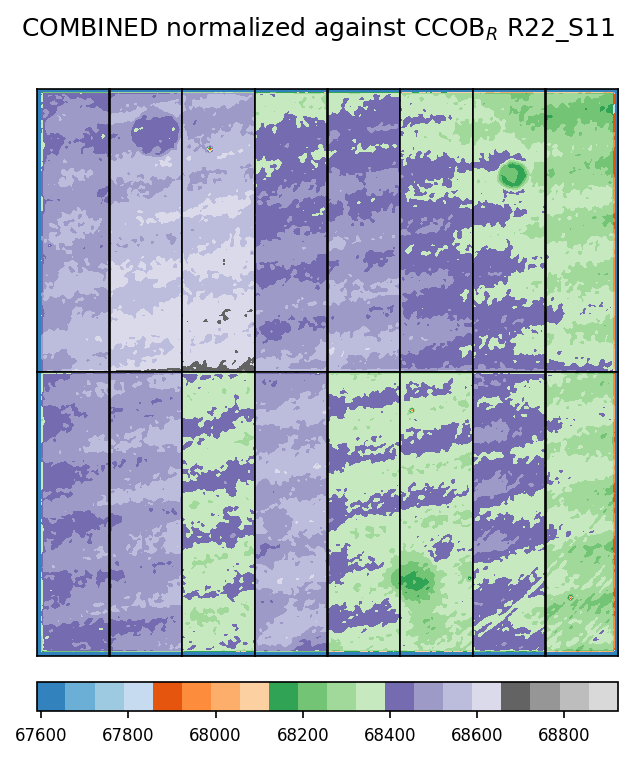

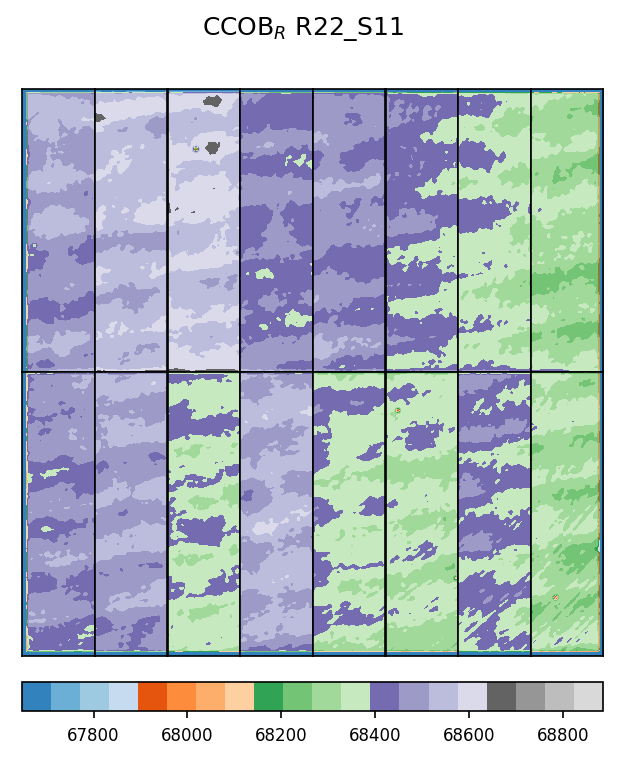

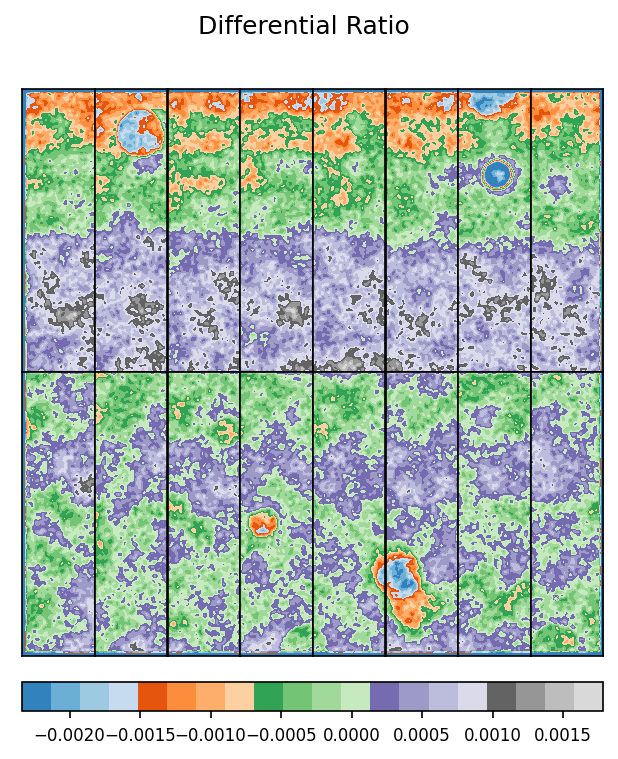

In [12]:
# Smoothed # 

# plot normalized, COMBINED flat
plotonesensor_E2V_smooth(normedimg_arr, 'COMBINED normalized against CCOB$_{R}$ R22_S11')

# plot CCOBred flat
plotonesensor_E2V_smooth(red_arr, 'CCOB$_{R}$ R22_S11')

# plot Ratio flat, the one of interest!
diff_arr = [None] * num_ch
for i in range(num_ch):
    diff_arr[i] = (normedimg_arr[i] - red_arr[i]) / red_arr[i]
plotonesensor_E2V_smooth(diff_arr, 'Differential Ratio')
    


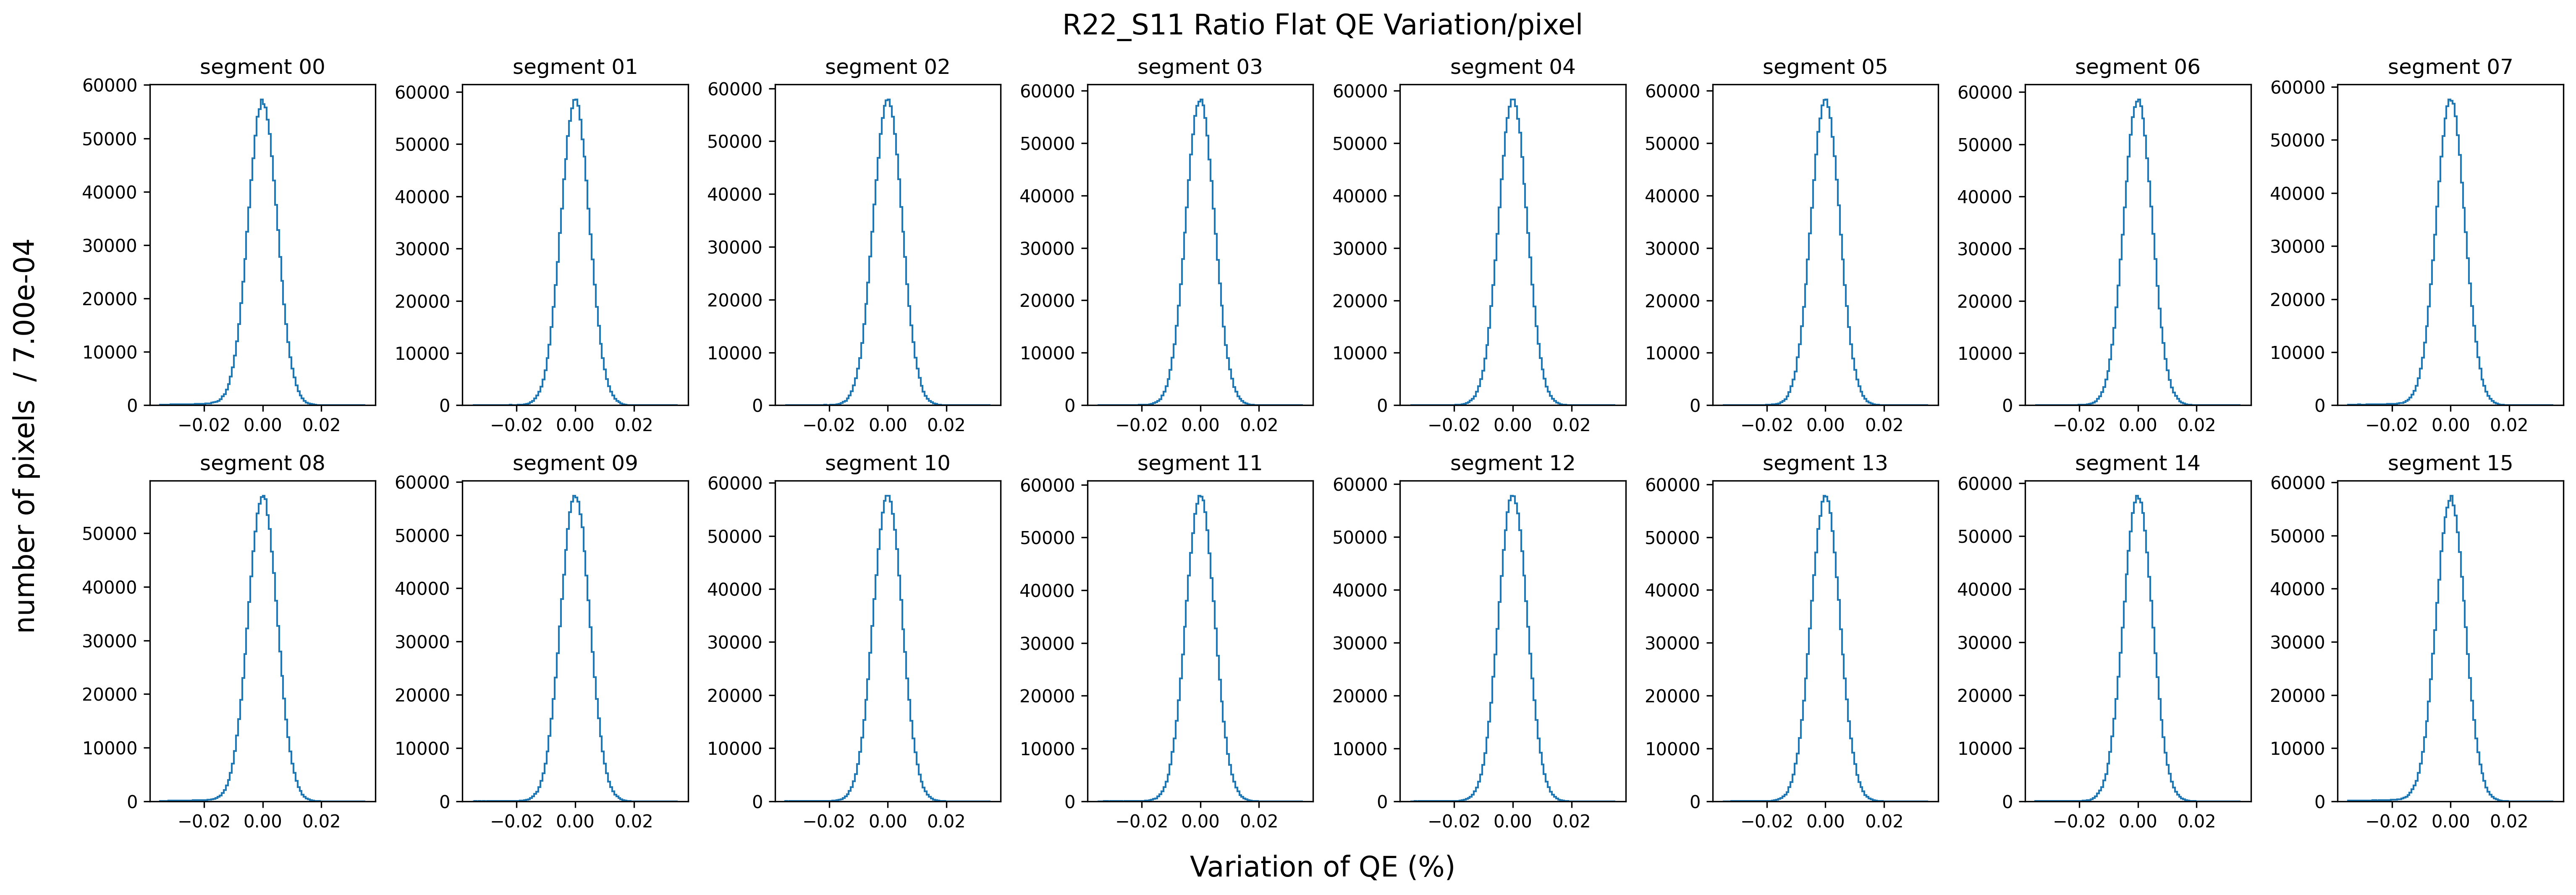

In [13]:
xmin= -0.035
xmax= 0.035
nbins= 101
bins= np.linspace(xmin, xmax, nbins)
width = (xmax-xmin)/ (nbins-1)


# creating histogram plots for R22_S11 ratio
fig, axs = plt.subplots(2, 8, figsize=(20,7),dpi=300) 
rows = 2    
columns = 8 
axs = axs.ravel()

fig.suptitle('R22_S11 Ratio Flat QE Variation/pixel', fontsize=16)
fig.text(0.5, 0.0, "Variation of QE (%)", ha='center', fontsize=16)
fig.text(-0.02, 0.5, "number of pixels  / %.2e" % width, va='center', rotation='vertical', fontsize=16)

for i in range(16):
    x = (normedimg_arr[i] - red_arr[i]) / red_arr[i]
    
    axs[i].hist(x.flat, bins=bins, histtype='step')
    
    if i > 9:
        axs[i].set_title("segment " + str(i))
    else:
        axs[i].set_title("segment 0" + str(i))
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()